In [45]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

## 데이터 준비

In [2]:
IMG_SIZE = 224

In [3]:
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir,'data')
camera_dir = os.path.join(data_dir,'CAMERA')
camera0_dir = os.path.join(camera_dir,'0')
camera1_dir = os.path.join(camera_dir,'1')

In [4]:
normal_img_files = os.listdir(camera0_dir)
fire_img_files = os.listdir(camera1_dir)

In [5]:
for img in normal_img_files:
    img_path = os.path.join(camera0_dir,img)
    image = Image.open(img_path)
    image_mode = image.mode
    if image_mode != 'RGB':
        print(img, image_mode)
        image = np.asarray(image)
        print(image.shape)
        os.remove(img_path)

for img in fire_img_files:
    img_path = os.path.join(camera1_dir,img)
    image = Image.open(img_path)
    image_mode = image.mode
    if image_mode != 'RGB':
        print(img, image_mode)
        image = np.asarray(image)
        print(image.shape)
        os.remove(img_path)
        
normal_img_files = os.listdir(camera0_dir)
fire_img_files = os.listdir(camera1_dir)

In [6]:
tfr_dir = os.path.join(camera_dir,'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

train_tfr_dir = os.path.join(tfr_dir,'train.tfr')
val_tfr_dir = os.path.join(tfr_dir,'val.tfr')

In [7]:
train_tfr_writer = tf.io.TFRecordWriter(train_tfr_dir)
val_tfr_writer = tf.io.TFRecordWriter(val_tfr_dir)

In [8]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [9]:
N_N_TRAIN = 3 * (len(normal_img_files) // 4)
for i, file in enumerate(normal_img_files):
    img_path = os.path.join(camera0_dir, file)
    image = Image.open(img_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    bimage = image.tobytes()
    
    example = tf.train.Example(features = tf.train.Features(feature = {
        'image':_bytes_feature(bimage),
        'cls_num':_int64_feature(0)
    }))
    if i < N_N_TRAIN:
        train_tfr_writer.write(example.SerializeToString())
    else:
        val_tfr_writer.write(example.SerializeToString())

In [10]:
N_F_TRAIN = 3 * (len(fire_img_files) // 4)
for i, file in enumerate(fire_img_files):
    img_path = os.path.join(camera1_dir,file)
    image = Image.open(img_path)
    image = image.resize((IMG_SIZE,IMG_SIZE))
    bimage = image.tobytes()
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'image':_bytes_feature(bimage),
        'cls_num':_int64_feature(1)
    }))
    
    if i < N_F_TRAIN:
        train_tfr_writer.write(example.SerializeToString())
    else:
        val_tfr_writer.write(example.SerializeToString())
train_tfr_writer.close()
val_tfr_writer.close()

In [11]:
N_TRAIN = N_F_TRAIN+N_N_TRAIN
N_VAL = len(fire_img_files)-N_F_TRAIN + len(normal_img_files)-N_N_TRAIN
N_BATCH = 32

In [12]:
def _parse_function(tfreced_serialized):
    features = {
        'image':tf.io.FixedLenFeature([],tf.string),
        'cls_num':tf.io.FixedLenFeature([],tf.int64)
    }
    
    parsed_features = tf.io.parse_single_example(tfreced_serialized,features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image,[IMG_SIZE,IMG_SIZE,3])
    image = tf.cast(image,tf.float32)/255.
    
    cls_label = tf.cast(parsed_features['cls_num'],tf.int64)
    
    return image, cls_label

In [13]:
train_dataset = tf.data.TFRecordDataset(train_tfr_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size = N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [14]:
val_dataset = tf.data.TFRecordDataset(val_tfr_dir)
val_dataset = val_dataset.map(_parse_function,num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

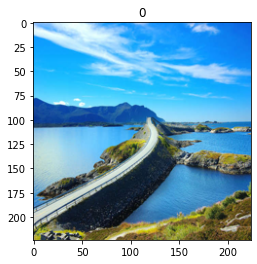

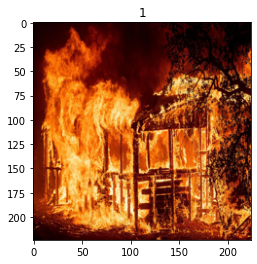

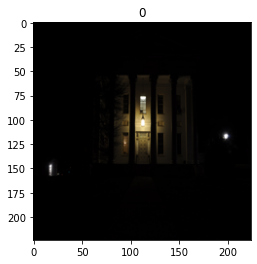

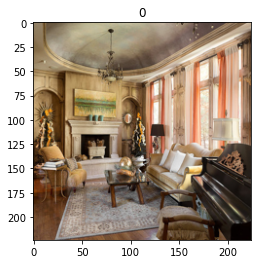

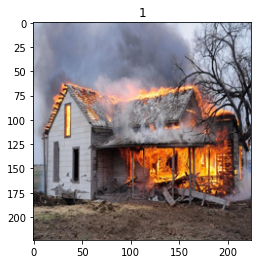

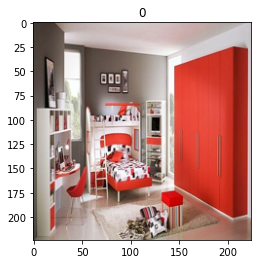

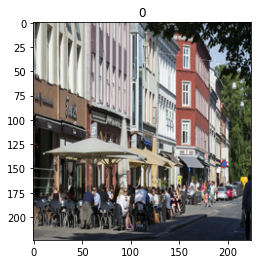

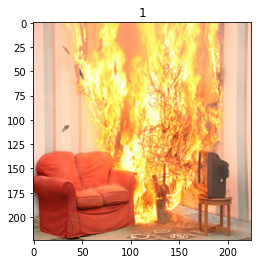

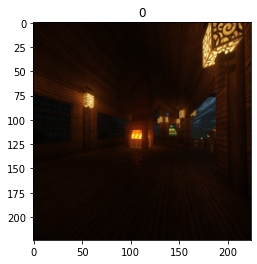

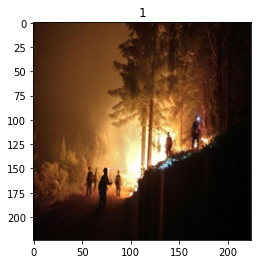

In [33]:
for image, label in train_dataset.take(10):
    if label[0].numpy()==1:
        plt.title('FIRE')
    else:
        plt.title('NOT FIRE')
    plt.imshow(image[0])
    plt.show()

## 모델 생성

In [47]:
def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu',padding='SAME', input_shape=(IMG_SIZE,IMG_SIZE,3)))
    model.add(tf.keras.layers.MaxPool2D(padding='SAME'))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu',padding='SAME'))
    model.add(tf.keras.layers.MaxPool2D(padding='SAME'))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu',padding='SAME'))
    model.add(tf.keras.layers.MaxPool2D(padding='SAME'))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu',padding='SAME'))
    model.add(tf.keras.layers.MaxPool2D(padding='SAME'))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu',padding='SAME'))
    model.add(tf.keras.layers.MaxPool2D(padding='SAME'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    return model

In [48]:
def loss_fn(y_true,y_pred):
    return keras.losses.MeanSquaredError()(y_true,y_pred)

In [49]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 256)      

In [50]:
N_EPOCHS = 30
learning_rate = 0.0001
steps_per_epoch = N_TRAIN/N_BATCH
validation_step = int(np.ceil(N_VAL / N_BATCH))

In [54]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                         decay_steps=steps_per_epoch*2,
                                                         decay_rate=0.5,
                                                         staircase=True)
model.compile(tf.keras.optimizers.RMSprop(lr_schedule),loss=loss_fn, metrics = ['accuracy'])

In [55]:
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=N_EPOCHS,
         validation_data=val_dataset,
         validation_steps=validation_step)

Epoch 1/30
43/43 [==============================] - 135s 3s/step - loss: 0.1111 - accuracy: 0.8582 - val_loss: 0.1021 - val_accuracy: 0.8766
Epoch 2/30
43/43 [==============================] - 139s 3s/step - loss: 0.0872 - accuracy: 0.8900 - val_loss: 0.1643 - val_accuracy: 0.7830
Epoch 3/30
43/43 [==============================] - 128s 3s/step - loss: 0.0643 - accuracy: 0.9075 - val_loss: 0.0688 - val_accuracy: 0.8979
Epoch 4/30
43/43 [==============================] - 136s 3s/step - loss: 0.0607 - accuracy: 0.9248 - val_loss: 0.0682 - val_accuracy: 0.8979
Epoch 5/30
43/43 [==============================] - 130s 3s/step - loss: 0.0533 - accuracy: 0.9358 - val_loss: 0.0797 - val_accuracy: 0.8979
Epoch 6/30
43/43 [==============================] - 128s 3s/step - loss: 0.0523 - accuracy: 0.9330 - val_loss: 0.0699 - val_accuracy: 0.9043
Epoch 7/30
43/43 [==============================] - 129s 3s/step - loss: 0.0486 - accuracy: 0.9364 - val_loss: 0.0592 - val_accuracy: 0.9255
Epoch 8/30
43

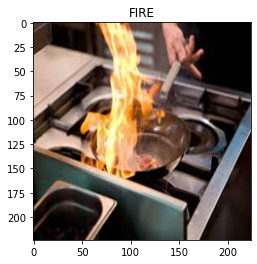

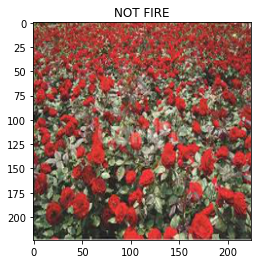

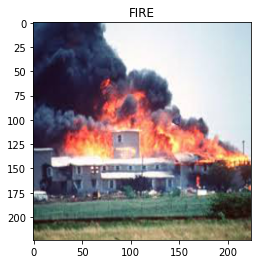

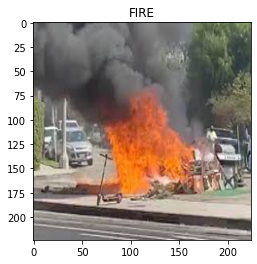

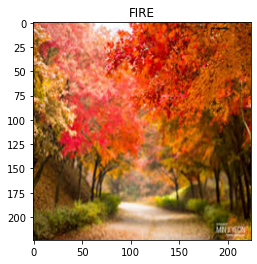

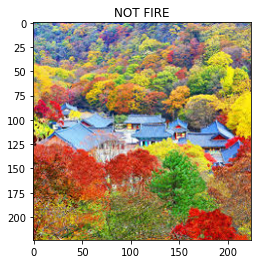

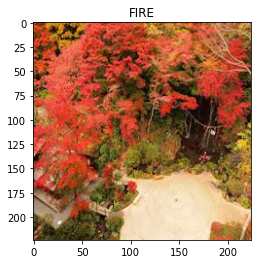

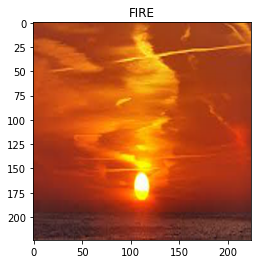

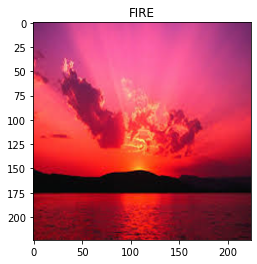

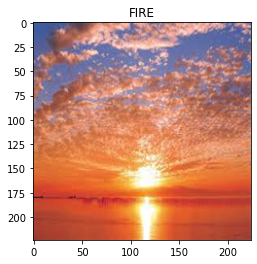

In [57]:
test_dir = os.path.join(camera_dir,'test')
test_img_files = os.listdir(test_dir)

for img in test_img_files:
    img_path = os.path.join(test_dir,img)
    image = Image.open(img_path)
    image_mode = image.mode
    if image_mode != 'RGB':
        print(img, image_mode)
        image = np.asarray(image)
        print(image.shape)
        os.remove(img_path)
        
test_img_files = os.listdir(test_dir)

for file in test_img_files:
    img_path = os.path.join(test_dir,file)
    image = Image.open(img_path)
    image = image.resize((IMG_SIZE, IMG_SIZE))
    image = tf.cast(np.array(image), tf.float32)/255.
    image = image[tf.newaxis,...]
    prediction = model.predict(image)
    
    if prediction>0.5:
        plt.title('FIRE')
    else:
        plt.title('NOT FIRE')
        
    plt.imshow(image[0])
    plt.show()